In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from datetime import timedelta
from utils import show_graph

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
mnist

Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f05342f65f8>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f053d8e9c88>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f053d8e9c18>)

The result is that mnist.train.images is a tensor (an n-dimensional array) with a shape of [55000, 784]. The first dimension is an index into the list of images and the second dimension is the index for each pixel in each image. Each entry in the tensor is a pixel intensity between 0 and 1, for a particular pixel in a particular image.

In [4]:
# mnist.train.next_batch is a method to shuffle the entire dataset,
#and return $mini_batch_size number of samples from the shuffled dataset.
batch_size = 20
for i in range(1):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    print("batch_xs:{}, batch_ys:{}".format(batch_xs.shape, batch_ys.shape))

batch_xs:(20, 784), batch_ys:(20, 10)


In [5]:
#First create placeholders to receive input values

#Create some test input to validate the shape

test_x_input = np.random.random((batch_size, 784))
test_y_input = np.random.random((batch_size, 10))
print("Test x input shape: {}".format(test_x_input.shape))
print("Test y input shape: {}".format(test_y_input.shape))


#Create a tensorflow placeholder of shape (batch_size, features) called x that will accept a matrix that have the shape of text_x_input, but use None
#as the batch_size so we can change that later on the fly

x = tf.placeholder(tf.float32, [None, test_x_input.shape[1]], name='x')
print("Validate shape of x: {}".format(x.get_shape().as_list()))

#Same for y, create a placeholder to hold target output classes
y = tf.placeholder(tf.float32, [None, test_y_input.shape[1]], name='y')
print("Validate shape of y: {}".format(y.get_shape().as_list()))

Test x input shape: (20, 784)
Test y input shape: (20, 10)
Validate shape of x: [None, 784]
Validate shape of y: [None, 10]


In [6]:
# x input needs to be reshaped to 4 dimensions for tf.convo2d.
# [ batch_size, height, width, depth(Channels, 1 for grayscale)]
x_4d = tf.reshape(x, [-1, 28, 28,1], name='x_4d')
print("x_4d shape: {}".format(x_4d.get_shape().as_list()))

x_4d shape: [None, 28, 28, 1]


In [ ]:
tf.reset_default_graph()

In [7]:
output_depth_1 = 32
# Create a default initial bias that is 0.1, that will be used 
# as a base for all biases in this network
initial_bias = tf.constant(0.1)
weight_1 = tf.Variable(tf.truncated_normal((5,5,1, output_depth_1),stddev=0.1) ,name='weights_1')
print("Dimensions of the first Weight/Filter: {}".format(weight_1.get_shape()))
bias_1 = tf.Variable(tf.constant(0.1, shape=([output_depth_1])), name='bias_1')
print("Bias dimensions of the first output layer will equal the number of output depth: {}".format(bias_1.get_shape()))

Dimensions of the first Weight/Filter: (5, 5, 1, 32)
Bias dimensions of the first output layer will equal the number of output depth: (32,)


In [8]:
convo_layer1 = tf.nn.conv2d(x_4d, weight_1, strides=[1,1,1,1], padding='SAME' )
convo_layer1 = tf.nn.bias_add(convo_layer1, bias_1)
convo_layer1 = tf.nn.relu(convo_layer1) #Use relu activation function before applying max pooling
maxpool_layer1 = tf.nn.max_pool(convo_layer1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
#Obtain the depth of the maxpool_layer1 in the 3rd dimension
maxpool_layer1_depth = maxpool_layer1.get_shape().as_list()[3]

In [9]:
convo_depth_2_output = 64

weight_2 = tf.Variable(tf.truncated_normal((5,5,maxpool_layer1_depth, convo_depth_2_output), stddev=0.1), name='weights_2')
print("Weight shapes for 2nd convolutional layer : {}".format(weight_2.get_shape().as_list()))
bias_2 = tf.Variable(tf.constant(0.1,shape=[convo_depth_2_output]), name='bias_2')

#Create the 2nd convolutional layer by applying convo2d on top of the previous maxpool_layer
convo_layer2 = tf.nn.conv2d(maxpool_layer1, weight_2, strides=[1,1,1,1], padding='SAME') + bias_2
convo_layer2 = tf.nn.relu(convo_layer2) 

#Apply the same maxpool layer
maxpool_layer2 = tf.nn.max_pool(convo_layer2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


#Create the Dense / Fully Connected layer
#First flatten the maxpool_layer2 with dimensions (None, 7, 7, 64)
mx_layer2_dims = maxpool_layer2.get_shape().as_list()
print("Preview the maxpool_layer2 output dimensions: {}".format(mx_layer2_dims))


Weight shapes for 2nd convolutional layer : [5, 5, 32, 64]
Preview the maxpool_layer2 output dimensions: [None, 7, 7, 64]


In [10]:
fc_layer = tf.reshape(maxpool_layer2, [-1, mx_layer2_dims[1] * mx_layer2_dims[2] * mx_layer2_dims[3]])
print("Reshaped FC layer Shape: {}".format(fc_layer.get_shape()))

fc_layer_dims = fc_layer.get_shape().as_list()


Reshaped FC layer Shape: (?, 3136)


In [11]:
fc_layer_1_output = 1024

weights_fc1 = tf.Variable(tf.truncated_normal([fc_layer_dims[1], 1024], stddev=0.1), name='weights_fc1')
print("Weights of Fully connected layer 1: {}".format(weights_fc1.get_shape().as_list()))
bias_fc1 = tf.Variable(tf.constant(0.1, shape=[fc_layer_1_output]), name='bias_fc1')
print("Fully connected layer 1 - Bias_fc1 shape : ", bias_fc1.get_shape().as_list())

#Perform linear regression on the dense layer, add a bias, and apply RELU activation
fc_layer1_z = tf.nn.bias_add(tf.matmul(fc_layer, weights_fc1),bias_fc1)
fc_layer_1_relu = tf.nn.relu(fc_layer1_z)
print("fc_layer1_activation shape", fc_layer_1_relu.get_shape().as_list())

#add Dropout on the first dense layer to prevent overfitting
keep_prob = tf.placeholder(tf.float32)
fc_layer_1_drop = tf.nn.dropout(fc_layer_1_relu, keep_prob)

#Final output layer
dims_fc_l1_drop = fc_layer_1_drop.get_shape().as_list()
print("Fully connected layer 1 output shape:",dims_fc_l1_drop)

# Create output with 10 classes
# Simply a linear regression on the 1st fully connected layer, and add a bias. Note: no softmax activation functions here
weights_fc2 = tf.Variable(tf.truncated_normal(shape=(dims_fc_l1_drop[1], 10), stddev=0.1), name='weights_fc2')
print("Weights shape for FC layer 2 : {}".format(weights_fc2.get_shape().as_list()))
bias_fc2 = tf.Variable(tf.constant(0.1, shape=[10]),name='bias_fc2')

fc_layer2 = tf.nn.bias_add(tf.matmul(fc_layer_1_drop, weights_fc2),bias_fc2)
print("Final FC layer2 shape, must be the same as the one hot encoded y input: {}".format(fc_layer2.get_shape().as_list()))

Weights of Fully connected layer 1: [3136, 1024]
Fully connected layer 1 - Bias_fc1 shape :  [1024]
fc_layer1_activation shape [None, 1024]
Fully connected layer 1 output shape: [None, 1024]
Weights shape for FC layer 2 : [1024, 10]
Final FC layer2 shape, must be the same as the one hot encoded y input: [None, 10]


In [13]:
#Create a subset of test images
mnist_val_x = mnist.test.images[:1000]
print(mnist_val_x.shape)
mnist_val_labels = mnist.test.labels[:1000]
print(mnist_val_labels.shape)

print("We'll test our model on 1000 examples from the MNIST test database")

(1000, 784)
(1000, 10)
We'll test our model on 1000 examples from the MNIST test database


In [14]:
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     predictions = sess.run(fc_layer2, feed_dict={x: mnist_test_x[:5], keep_prob: 1.0})
#     print("fc_layer2 output shape:{}".format(predictions.shape)) #5 rows, 10 columns
    
#     #Peek into 5 rows of predictions
#     print("Peek into the 5 rows of final fully connected layer 2 output predictions:\n{}".format(predictions))
    
#     # Calling tf.argmax with axis = 1 on a predictions, will return the index/column that contains
#     # the largest value
    
#     pred_argmax = sess.run(tf.argmax(predictions,1))
#     print("tf argmax on predictions returns 5 values (corresponding to 5 rows) :\n{}".format(pred_argmax))
#     print("\nTaking the 0th row (prediction[0]) as an example:{}\nThe higheset value in this row is:{} which is column: [{}]"
#           .format(predictions[0],np.max(predictions),pred_argmax[0]))
    
    
#     print("\nPeek into 5 rows of target mnist_test_labels:\n{}".format(mnist_test_labels[:5]))
#     actual_argmax = sess.run(tf.argmax(mnist_test_labels[:5], 1))
#     print("Index of columns with the correct target: {}".format(actual_argmax))
    
#     print("Predictions vs target:\n{}\n{}".format(pred_argmax,actual_argmax))
    
#     correct_predictions = sess.run(tf.equal(pred_argmax,actual_argmax))
    
#     print("correct_predictions vector: {}".format(correct_predictions))

#     prediction_numbers = sess.run(tf.cast(correct_predictions, tf.float32))
#     print("correct_predictions_in_numbers: {}".format(prediction_numbers))

#     # Now calculate the accuracy by simply obtaining the mean of this vector, where 1 is a correct prediction and 0 is a wrong
#     # prediction
#     accuracy = sess.run(tf.reduce_mean(prediction_numbers))
#     print("Accuracy: {}".format(accuracy))
#     print("\nNote:The accuracy at this stage should be terrible and totally random, since we have not trained the model yet.")


In [15]:
#Create cross_entropy to be used in Adam optimizer
with tf.name_scope("cross_ent"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=fc_layer2)
    cost = tf.reduce_mean(cross_entropy)
    print(cost)
    
with tf.name_scope("Optimizer"):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cost)
    
with tf.name_scope("accuracy"):
    correct_predictions = tf.equal(tf.argmax(fc_layer2,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Tensor("cross_ent/Mean:0", shape=(), dtype=float32)


In [16]:
writer = tf.summary.FileWriter("Training_FileWriter/")
writer1 = tf.summary.FileWriter("Validation_FileWriter/")

tf.summary.scalar('loss', cost)
tf.summary.scalar('accuracy', accuracy)
merged_summary = tf.summary.merge_all()  

In [17]:
save_file = './saved_models/cnn_model_0.ckpt' 

saver = tf.train.Saver()

In [30]:
batch_size = 64

iterations = 1000
reporting_count = 20
writer = tf.summary.FileWriter('/home/user/Downloads/saved_models/',tf.get_default_graph())
total_loss = []
train_acc =[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    start_time = time.time()
    for i in range(iterations):
        
        batch_xs, batch_ys = mnist.train.next_batch(batch_size) # selecting the batches permutationally
        _, loss,summary = sess.run([train_step,cost,merged_summary], feed_dict={x: batch_xs, y: batch_ys, keep_prob: 0.5})
        writer.add_summary(summary,i)
        #output = sess.run(train_step, feed_dict={x:batch_xs, keep_prob:0.5, y:batch_ys})
  #      train_step.run(feed_dict={x: batch[0], y:batch[1], keep_prob: 0.5})
        if i % 100 == 0:
            #summary = sess.run([merged], feed_dict=feed_dict(False))
            train_ac = sess.run(accuracy,feed_dict={x:mnist_val_x, y:mnist_val_labels, keep_prob:1.0 })
            print("Validation(Training) accuracy:{} {}% completed".format(train_ac, i/iterations * 100 ))
            print( "loss : {}". format(loss))
            print("Batch {} completed!".format(i))
        
        train_acc.append(train_ac)
        total_loss.append(loss)
    print("Train Complete!")
    # Ending time.
    end_time = time.time()
    print(end_time)
    # Difference between start and end-times.
    time_dif = end_time - start_time
    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

    #Remember to save model!
    saver.save(sess, save_file)
    print("Model saved as {}".format(save_file))
writer.close()   

Validation(Training) accuracy:0.13600000739097595 0.0% completed
loss : 9.151334762573242
Batch 0 completed!
Validation(Training) accuracy:0.8259999752044678 10.0% completed
loss : 0.6933172345161438
Batch 100 completed!
Validation(Training) accuracy:0.8849999904632568 20.0% completed
loss : 0.8406227827072144
Batch 200 completed!
Validation(Training) accuracy:0.9079999923706055 30.0% completed
loss : 0.5266677141189575
Batch 300 completed!
Validation(Training) accuracy:0.9210000038146973 40.0% completed
loss : 0.3992910385131836
Batch 400 completed!
Validation(Training) accuracy:0.9330000281333923 50.0% completed
loss : 0.25437986850738525
Batch 500 completed!
Validation(Training) accuracy:0.9399999976158142 60.0% completed
loss : 0.29847970604896545
Batch 600 completed!
Validation(Training) accuracy:0.949999988079071 70.0% completed
loss : 0.28659918904304504
Batch 700 completed!
Validation(Training) accuracy:0.953000009059906 80.0% completed
loss : 0.36715763807296753
Batch 800 comp

In [ ]:
show_graph(tf.get_default_graph().as_graph_def())

# Create a test set of 5000 images from the whole set (only necessary to overcome RAM limitations, otherwise use the full test set)

In [31]:
print("Total number of test images: {}".format(len(mnist.test.images)))

mnist_test_x_fromlast = mnist.test.images[-1000:]
print(mnist_test_x_fromlast.shape)
mnist_test_y_fromlast = mnist.test.labels[-1000:]
print(mnist_test_y_fromlast.shape)

Total number of test images: 10000
(1000, 784)
(1000, 10)


In [32]:
best_trained_model_path = './saved_models/cnn_model_0.ckpt' 

# Uncomment this to use your own trained model instead
save_file = best_trained_model_path

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, save_file)
    loss1= sess.run([cost], feed_dict={x: mnist_test_x_fromlast, y: mnist_test_y_fromlast, keep_prob: 1.0})
    print ( " Loss : {}". format(loss1))
    test_ac =sess.run(accuracy,feed_dict={x:mnist_test_x_fromlast, y:mnist_test_y_fromlast, keep_prob:1.0 })
    #output = sess.run(accuracy, feed_dict={x:mnist_test_x_fromlast, y:mnist_test_y_fromlast, keep_prob:1.0 })
    print("Final_test Accuracy :{}".format(test_ac))
    # Both ways are equivalent
    print("Test Accuracy Eval:{}".format(accuracy.eval(feed_dict={x:mnist_test_x_fromlast, y:mnist_test_y_fromlast, keep_prob:1.0 }) * 100 ))

print("Test complete!")

INFO:tensorflow:Restoring parameters from ./saved_models/cnn_model_0.ckpt
 Loss : [0.12959461]
Final_test Accuracy :0.9589999914169312
Test Accuracy Eval:95.89999914169312
Test complete!


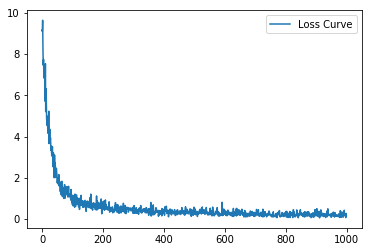

In [33]:
plt.figure()
plt.plot(total_loss, label = 'Loss Curve')
plt.legend()
plt.show()

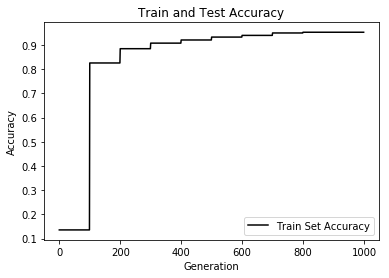

In [34]:
#eval_indices = range(0, iterations, 100)
plt.plot(train_acc, 'k-', label='Train Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

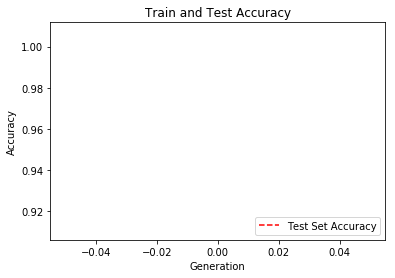

In [36]:
plt.plot(test_ac, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()